# OFDM Radar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from ofdmradar import Constellation, OFDMRadar

%matplotlib inline

In [2]:
plt.rc("figure", figsize=(10, 10))

In [3]:
qpsk = Constellation("QAM", 4)
qam16 = Constellation("QAM", 16)
qam256 = Constellation("QAM", 256)
bpsk = Constellation("BPSK")

In [4]:
modpos = qam16.modulate_data(np.arange(8))

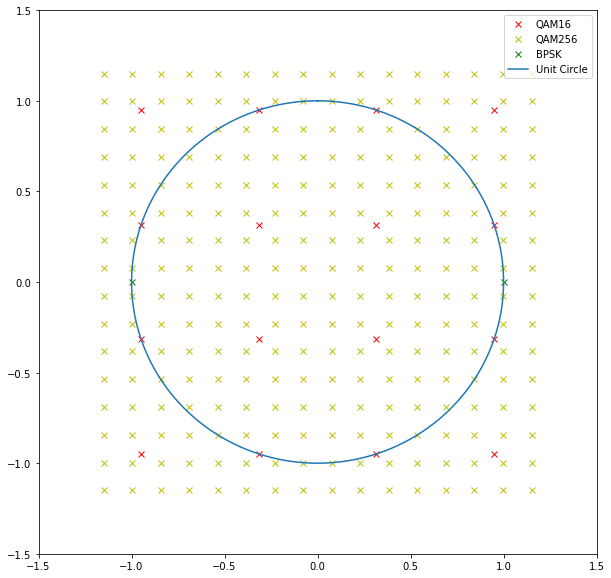

In [5]:
#plt.plot(np.real(modpos), np.imag(modpos), "go", markersize=15)

plt.plot(np.real(qam16.symbols), np.imag(qam16.symbols), "rx")
plt.plot(np.real(qam256.symbols), np.imag(qam256.symbols), "yx")
plt.plot(np.real(bpsk.symbols), np.imag(bpsk.symbols), "gx")

t = np.linspace(0, 1, 1024)
plt.plot(np.sin(2*np.pi*t), np.cos(2*np.pi*t))

plt.legend(["QAM16", "QAM256", "BPSK", "Unit Circle"])
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5]);

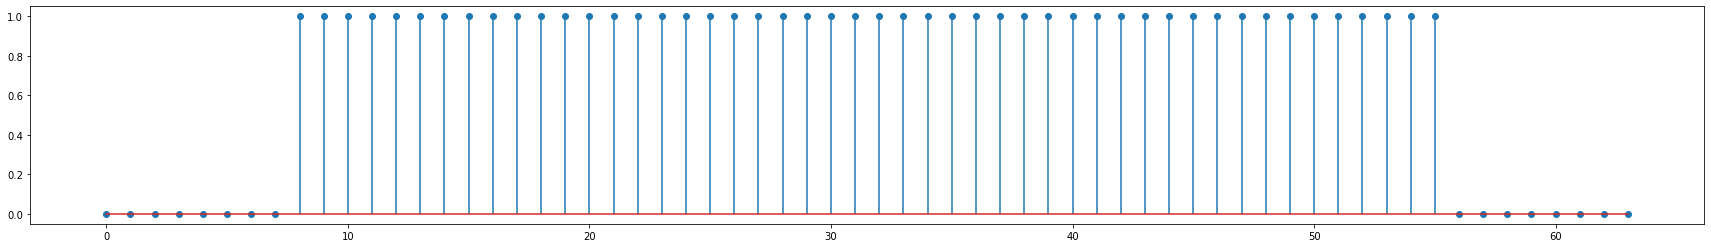

In [6]:
def genmask(carriers=64, dc_guard=2, nyquist_guard=8):
    i = np.arange(carriers, dtype=np.uint32)
    
    # return i + nyquist_guard - carriers//2 >= nyquist_guard*2
    return np.logical_and(np.logical_not(np.logical_or(i > carriers - dc_guard, i < dc_guard)), i + nyquist_guard - carriers//2 >= nyquist_guard*2)
    # return np.logical_or(dc_guard + 1 < carriers - i, i <= dc_guard - 1)
    # return np.logical_or(i <= dc_guard)
    # return np.logical_and(np.logical_not(np.logical_or(i <= dc_guard, dc_guard <= carriers - i)), np.array([True]*carriers))

# for (size_t = 0; i < carrier_mask.size(); i++) {
#     // DC guard
#     if (i <= dc_guard || dc_guard <= carriers - i)
#         continue;
# 
#     // Nyquist guard
#     if (i + nyquist_guard - (carriers << 1) <= nyquist_guard)
#         continue;
# }
plt.figure(figsize=(30, 4))
plt.stem(np.fft.fftshift(genmask(dc_guard=0)));
# plt.stem(genmask());

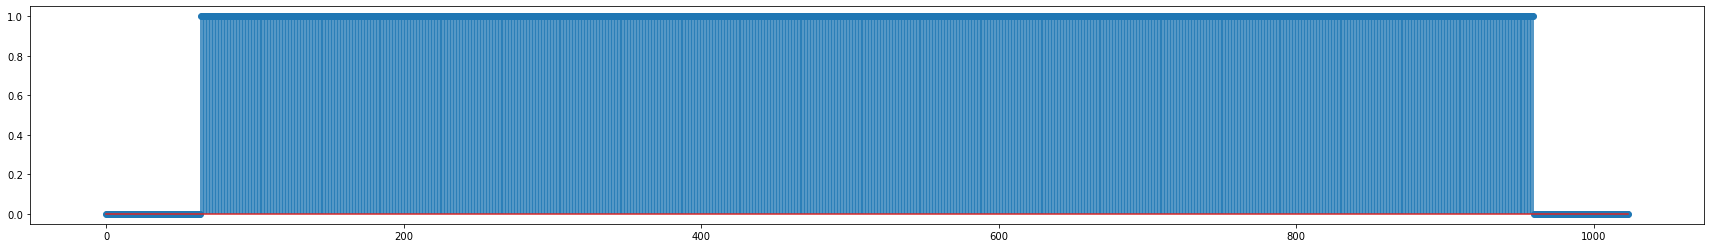

In [7]:
ofdm = OFDMRadar(N=1024, N_guard=128, N_border_margin=64, M=128, const=qam16)
plt.figure(figsize=(30, 4))
plt.stem(np.fft.fftshift(ofdm.carrier_mask));

In [8]:
np.all(genmask(carriers=1024, dc_guard=1, nyquist_guard=64) == ofdm.carrier_mask)

False

In [9]:
F_tx, ofdm_signal = ofdm.generate_random_frame(0)

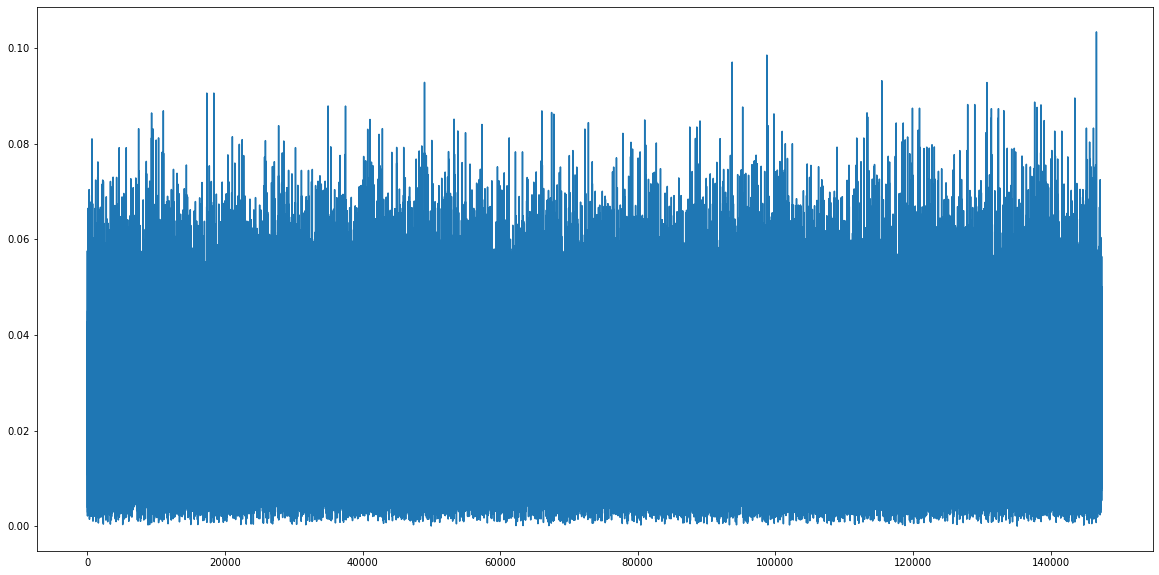

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(np.abs(ofdm_signal))

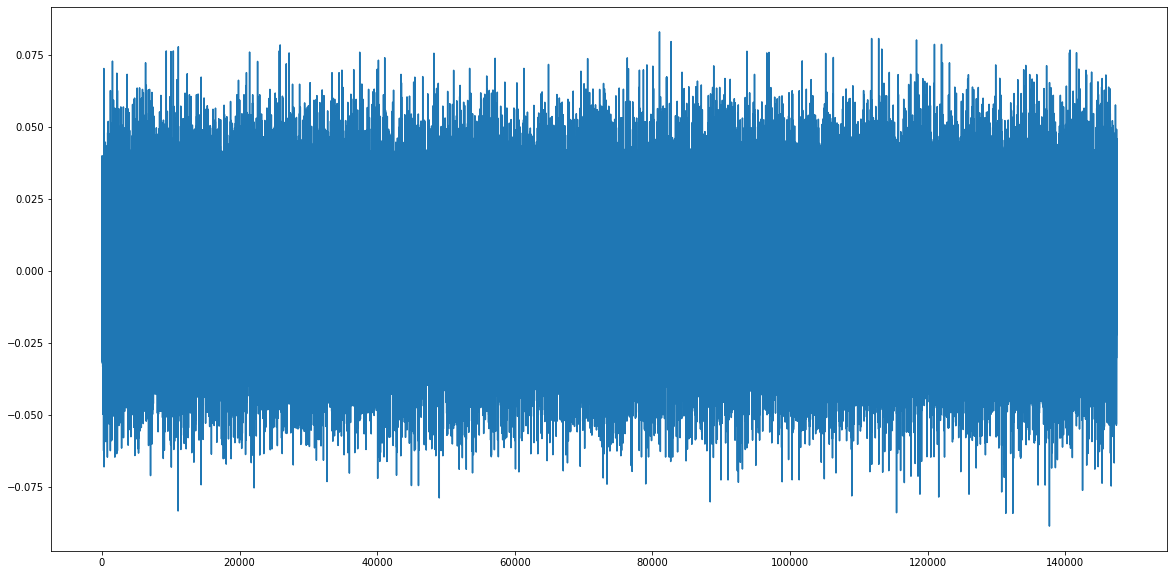

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(np.real(ofdm_signal))
# plt.plot(np.imag(ofdm_signal))

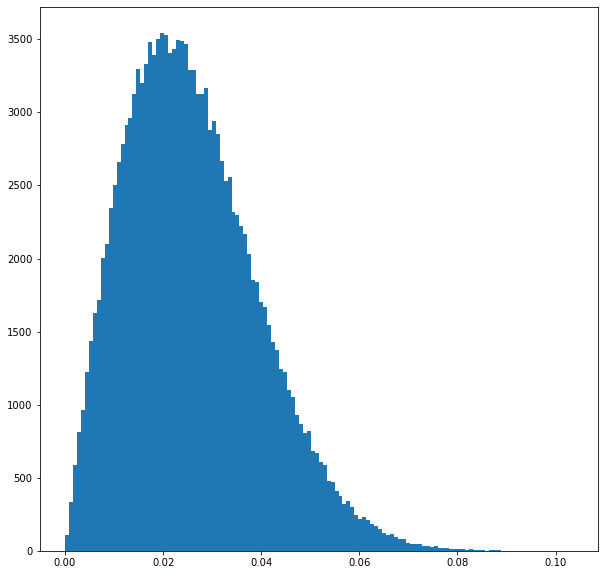

In [12]:
plt.hist(np.abs(ofdm_signal), bins=128);

In [13]:
power = np.abs(ofdm_signal * np.conj(ofdm_signal))
papr = 10 * np.log10(np.max(power) / np.mean(power))
pavg = 10 * np.log10(np.mean(power))

(-60.0, -20.0)

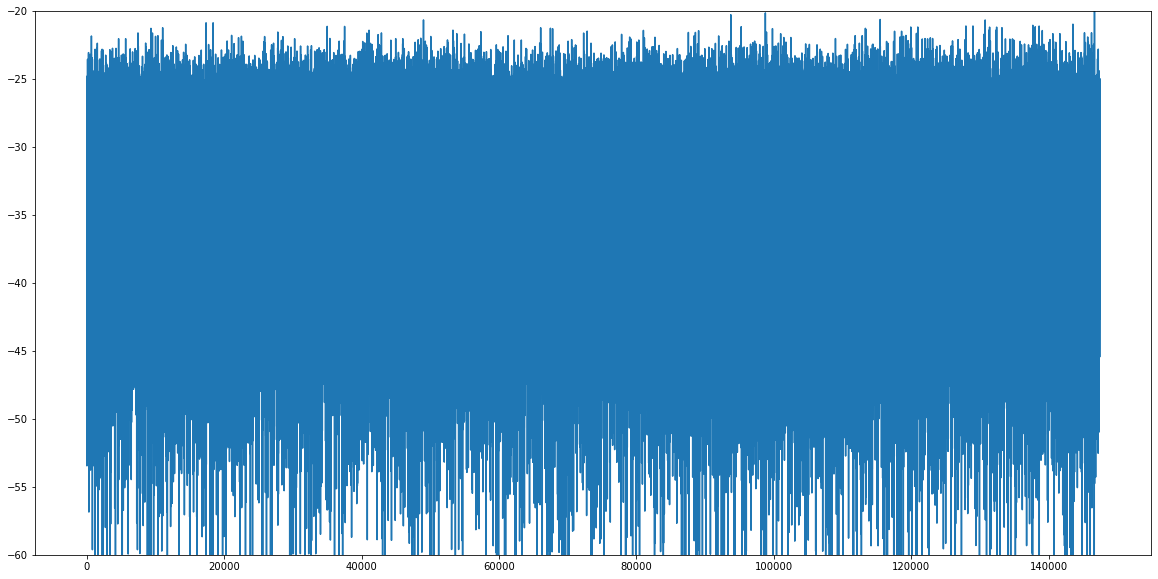

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(10 * np.log10(power))
plt.hlines(pavg, -100, len(ofdm_signal)+100, "r")
plt.hlines(pavg + papr, 0, len(ofdm_signal)-1, "r")
plt.ylim([-60, -20])

In [15]:
channel = np.zeros(256)
channel[127+10] = 0.2
channel[127+50] = 0.5
channel[127+72] = 0.1
channel[127+99] = 0.1

In [16]:
len(channel)

256

In [17]:
ofdm_signal_rx = np.convolve(ofdm_signal, channel, mode="same") + np.random.randn(len(ofdm_signal))*0.02

In [18]:
len(ofdm_signal_rx)

147456

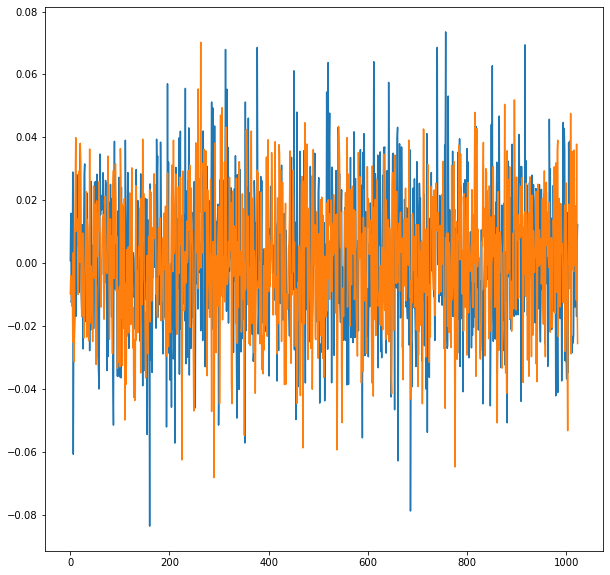

In [19]:
plt.plot(np.real(ofdm_signal_rx[:1024]))
plt.plot(np.real(ofdm_signal[:1024]))

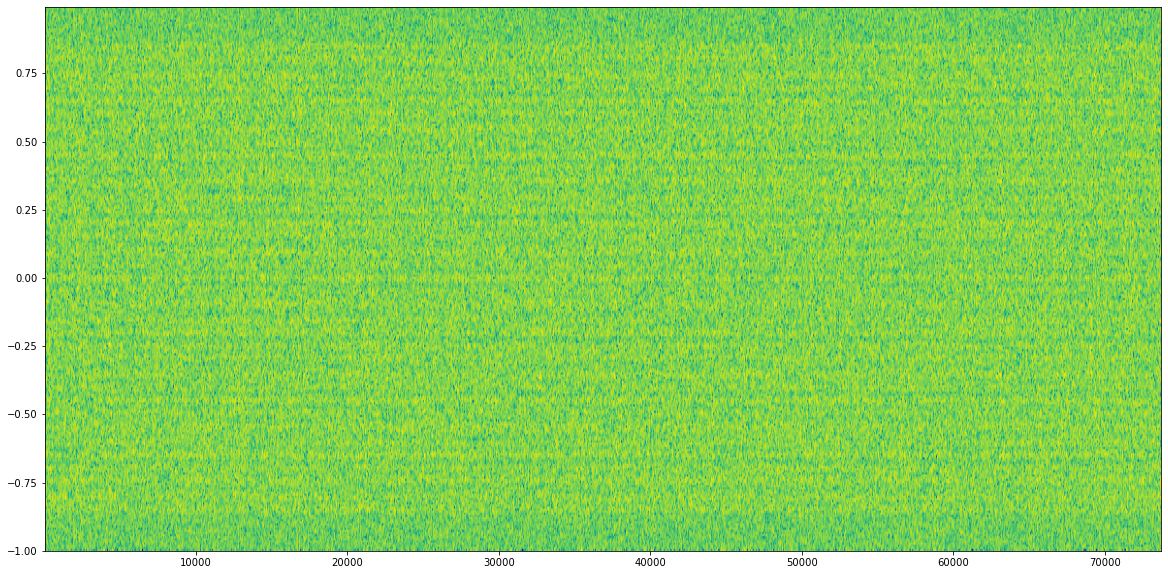

In [20]:
plt.figure(figsize=(20, 10))
plt.specgram(ofdm_signal_rx);

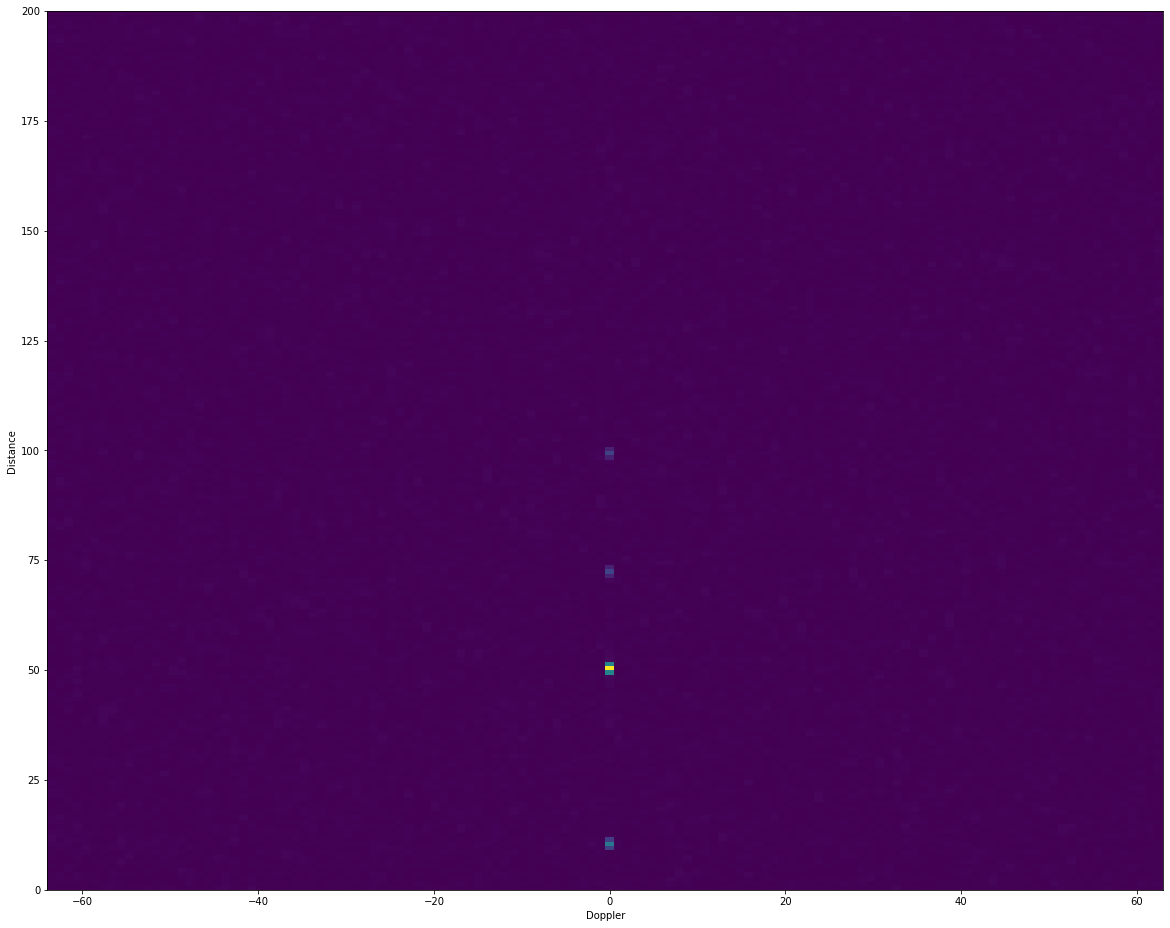

In [21]:
estimate = ofdm.periodogram(F_tx, ofdm_signal_rx)

plt.figure(figsize=(20, 20))
plt.imshow(np.abs(estimate)[::-1,:], interpolation="none", aspect=1/2, extent=[-64, 63, 0, 1023])
# plt.colorbar()
plt.ylim([0, 200])
plt.ylabel("Distance")
plt.xlabel("Doppler");